In [2]:
from bertopic import BERTopic
from bertopic.dimensionality import BaseDimensionalityReduction
from bertopic.representation import MaximalMarginalRelevance

from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
# from umap import UMAP
import sys, gzip, torch, pickle
sys.path.insert(0,'../code/')
from core import *
from pprint import pprint
import matplotlib.pyplot as plt
from umap import UMAP
import plotly.express as px
import pandas as pd
import numpy as np
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from rapidfuzz import fuzz

device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
data_folder = '../data/'
model_folder = '../models/'
load = True

[2023-10-04 11:38:19,072] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
# getting a dictioary with most common words
with open(data_folder + 'dictionaries/words_alpha.txt', 'r') as f:
    EN = f.read().split('\n')
    EN = set([w.lower() for w in EN if len(w) > 1])

with gzip.open(data_folder + 'text.pickle.gzip','rb') as f:
    data = pickle.load(f)
data = {k : data[k] for k in data if k.startswith('/home/as/Documents/proceedings/data_local/proc/')} # not using book corpus
titles = get_titles(data)
abstracts = get_abstracts(data, word_dict = EN)

100%|██████████| 40381/40381 [00:34<00:00, 1168.23it/s]


Selecting Conference

In [4]:
abstracts = {k : abstracts[k] for k in abstracts if 'icalepcs' == k.split('/')[7] or 'ipac' == k.split('/')[7]}
# abstracts = {k : abstracts[k] for k in abstracts if 'ipac' == k.split('/')[7]}

In [5]:
vectorizer_model = CountVectorizer(stop_words="english")
# umap = UMAP(n_neighbors=15, verbose = True, metric = 'cosine', random_state = 42)
embedding = SentenceTransformer(model_folder + '/02_simcse-model-full-papers', device = device)
# embedding = SentenceTransformer('princeton-nlp/sup-simcse-roberta-base', device = device)

### BERTopic

In [6]:
nr_topics = 32
topic_model = BERTopic(verbose=True, 
                       vectorizer_model= vectorizer_model, 
                       embedding_model = embedding,
                       nr_topics=nr_topics,
                       calculate_probabilities = True)

if not load:
    
    e = embedding.encode(list(abstracts.values()))
    et = umap.fit_transform(e)
    
    # https://maartengr.github.io/BERTopic/api/bertopic.html#bertopic._bertopic.BERTopic.__init__
    # https://maartengr.github.io/BERTopic/getting_started/vectorizers/vectorizers.html#countvectorizer
    topics, probs = topic_model.fit_transform(abstracts.values())
    
    
    print('\n\n\nSaving is commented!!!! For safety reasons to not override it!!!!\n\n\n')
    '''
    topic_model.save(data_folder + '/bertopic/bertopic.pkl')
    with gzip.open(data_folder + '/bertopic/embedding.pkl.gzip','wb') as f:
        pickle.dump({'embedding' : e,
                     'reduced_embedding' : et},f)
    '''
else:
    topic_model = BERTopic.load(data_folder + '/bertopic/bertopic.pkl')
    topics = topic_model.topics_
    probs = topic_model.probabilities_
    
    
    with gzip.open(data_folder + '/bertopic/embedding.pkl.gzip','rb') as f:
        data = pickle.load(f)
        e = data['embedding']
        et = data['reduced_embedding']
    

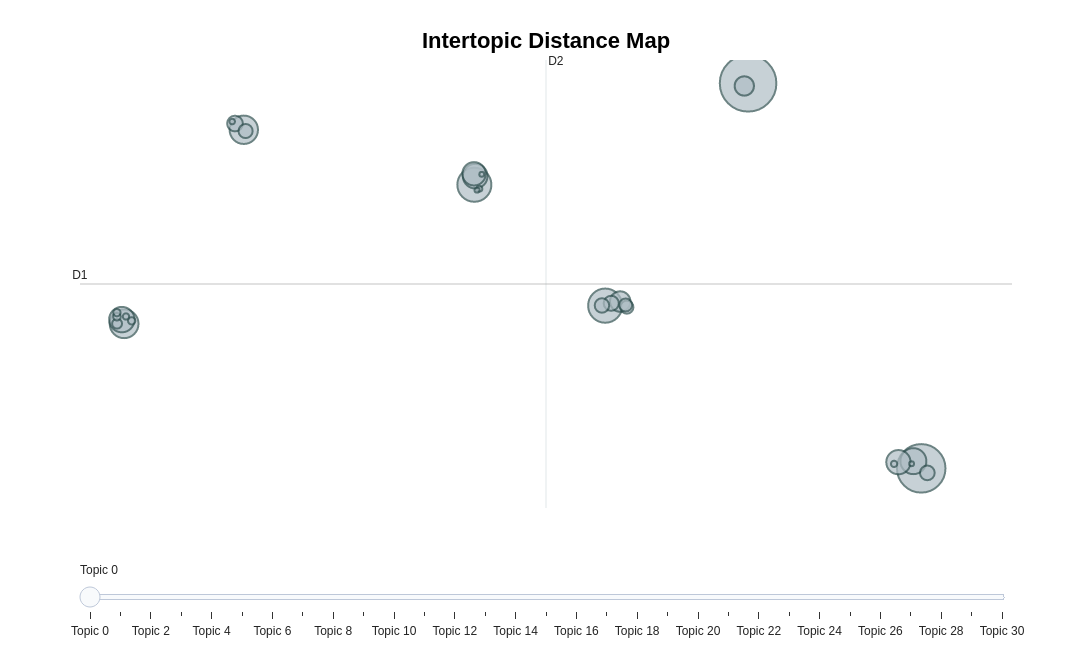

In [7]:
topic_model.visualize_topics()

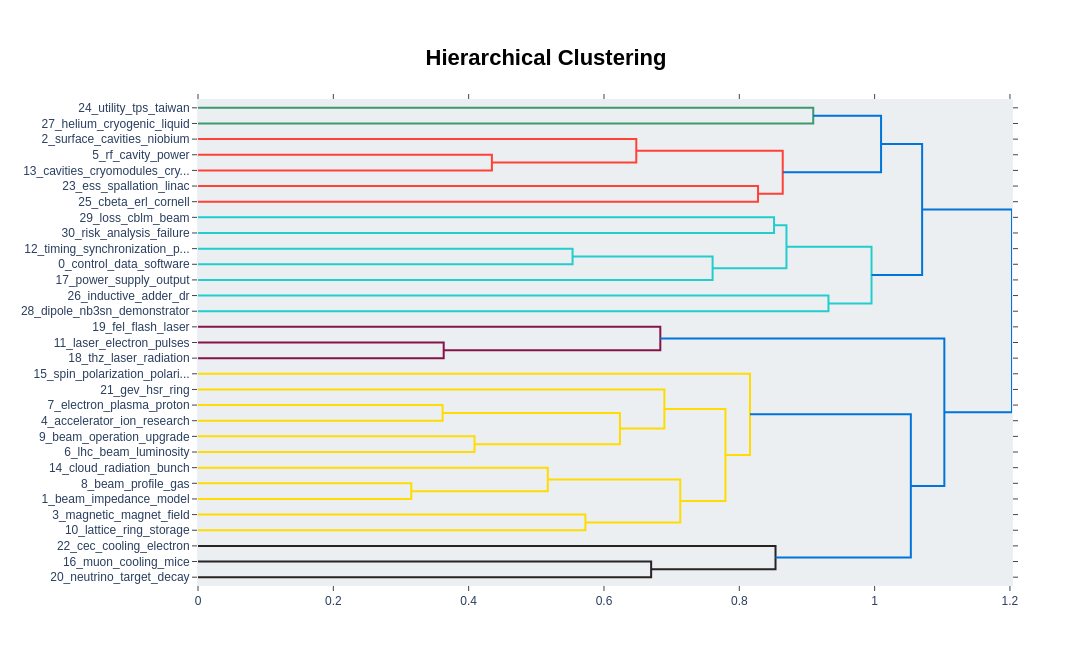

In [8]:
topic_model.visualize_hierarchy()

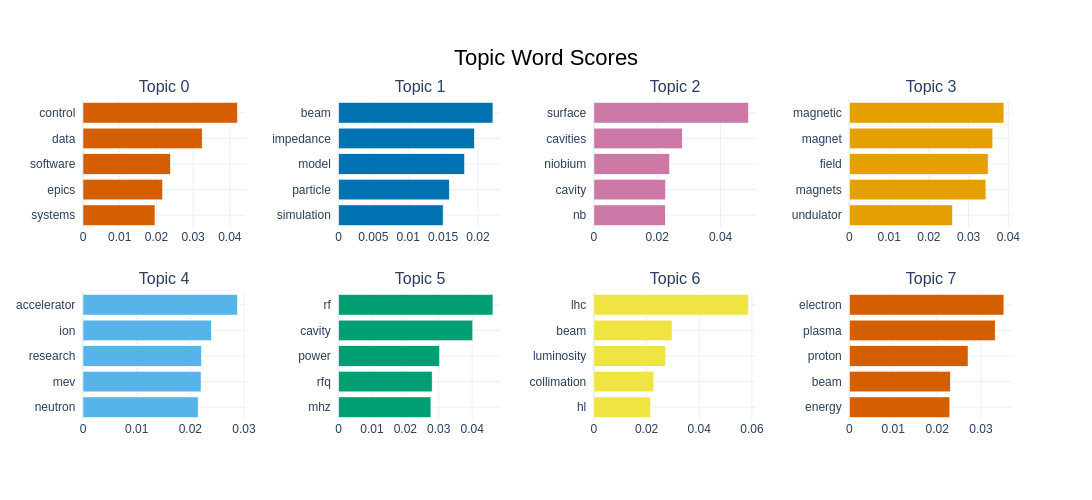

In [9]:
topic_model.visualize_barchart()

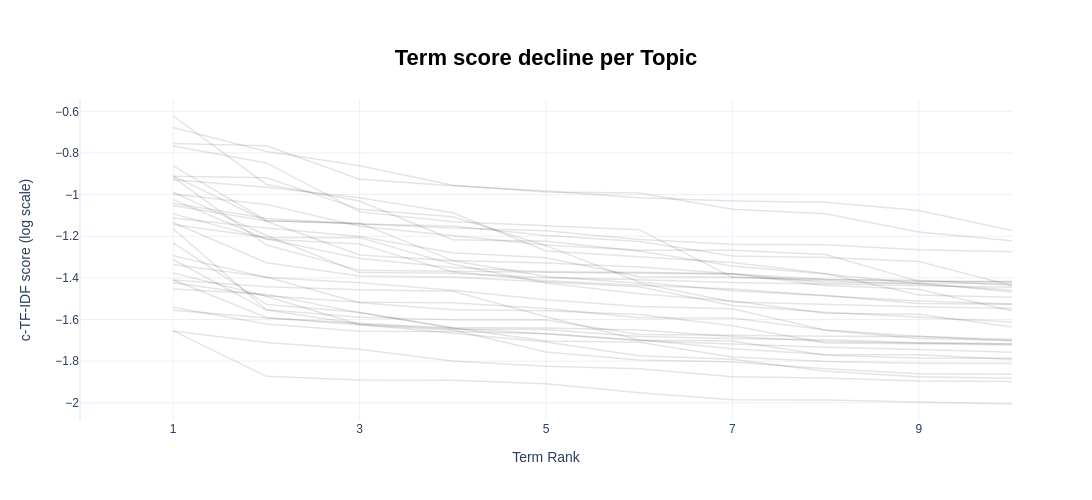

In [10]:
topic_model.visualize_term_rank(log_scale=True)

In [11]:
old_topics = topics

In [12]:
topics = topic_model.reduce_outliers(list(abstracts.values()), topics, probabilities=probs, strategy="probabilities")

## Visualisations for Paper

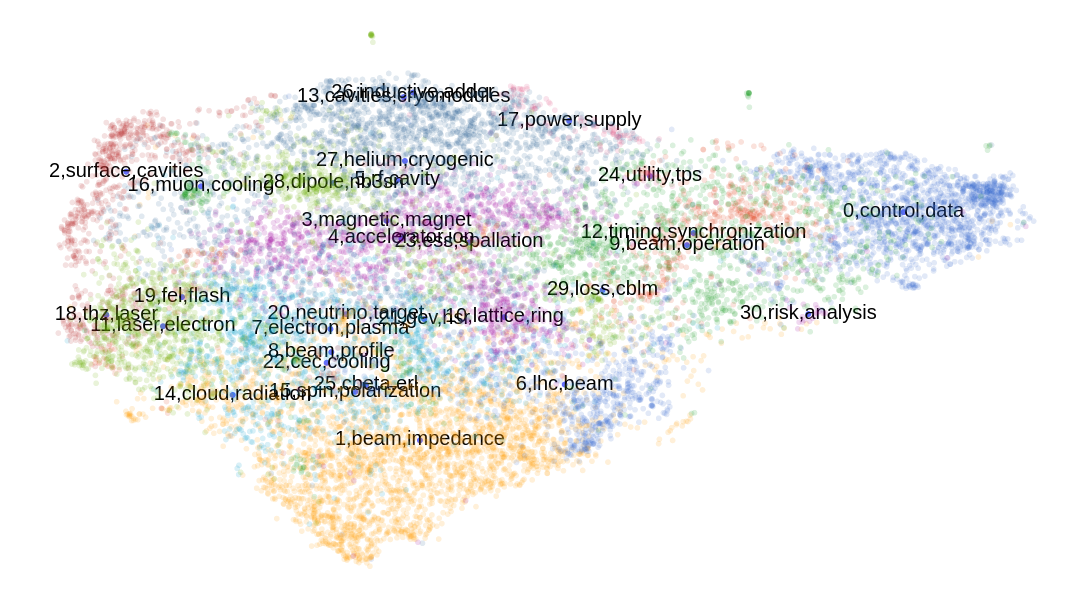

In [13]:
# 
# POINTS
# 
df = pd.DataFrame.from_dict({'x' : et[:,0], 'y' : et[:,1], 
                             'Topic' : topics,
                             'Title' : [(titles[k] if titles[k] != None else k) for k in abstracts]})
df = df[df['Topic'] != -1]
df['Topic'] = [str(x).zfill(2) for x in df['Topic']]

fig1 = px.scatter(df, x = 'x', y = 'y', 
                 color = 'Topic', 
                 custom_data=['Title'],
                 opacity=0.15,
                 color_discrete_sequence=px.colors.qualitative.G10)
fig1.update_traces(mode="markers",
                   hovertemplate = '%{customdata[0]}')

#
# TOPICS 
#
topic_labels = topic_model.get_topic_info()
# topic_labels.loc[topic_labels['Topic'] == t,'Name'].values[0]
topic_centers_x = {t : et[np.array(topics)==t,0].mean() for t in set(topics) if t != -1}
topic_centers_y = {t : et[np.array(topics)==t,1].mean() for t in set(topics) if t != -1}
df_topic_centers_x = pd.DataFrame.from_dict({'Topic' : list(topic_centers_x.keys()), 'x' : list(topic_centers_x.values())}).set_index('Topic')
df_topic_centers_y = pd.DataFrame.from_dict({'Topic' : list(topic_centers_y.keys()), 'y' : list(topic_centers_y.values())}).set_index('Topic')
df_topic_centers = df_topic_centers_x.join(df_topic_centers_y).join(topic_labels.set_index('Topic'))
df_topic_centers['Name'] = df_topic_centers['Name'].map(lambda x : ",".join(x.split('_')[:3]))
df_topic_centers = df_topic_centers.reset_index('Topic')
df_topic_centers['Topic'] = [str(x).zfill(2) for x in df_topic_centers['Topic']]


fig2 = px.scatter(df_topic_centers,x = 'x',y = 'y', text = 'Name', opacity = 1)
fig2.update_traces(textfont_size=20, textfont_color="black")

fig3 = go.Figure(data=fig2.data + fig1.data)
fig3.update_xaxes(showgrid=False, 
                 showticklabels=False,
                 visible=False)
fig3.update_yaxes(# scaleanchor="x", 
                 # scaleratio=0.8,
                 showgrid=False,
                 showticklabels=False,
                 visible=False)
fig3.update_layout(autosize=False, 
                   width=800, height=600,
                   showlegend=False, 
                   plot_bgcolor='rgba(0, 0, 0, 0)',
                   margin=dict(l=0, r=0, b=0, t=0, pad=0))


fig3.show()
fig3.write_image("/home/sulcan/TU2AO02_2.pdf")

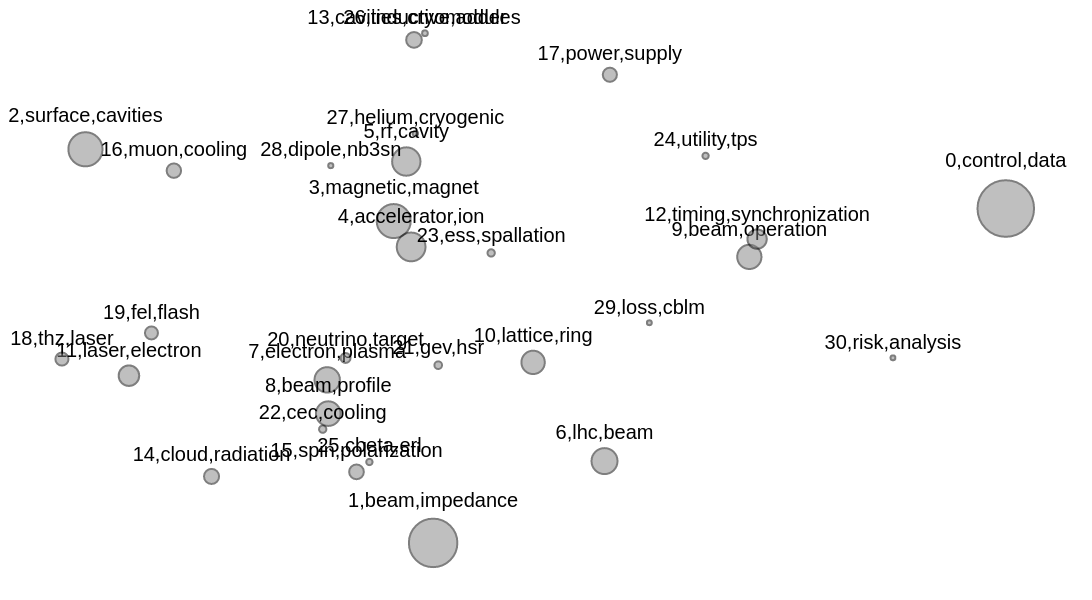

In [14]:
fig = px.scatter(df_topic_centers,x = 'x',y = 'y', 
                 size = 'Count', 
                 color = 'Topic', 
                 text = 'Name', 
                 opacity = 0.5, 
                 size_max = 40)

fig.update_traces(textfont_size=20,
                  marker=dict(
                      color='Gray',
                      line=dict(color='Black', width=2)
                  ),
                  textposition='top center',
                  textfont_color="black")
fig.update_xaxes(showgrid=False, 
                 showticklabels=False,
                 visible=False)
fig.update_yaxes(# scaleanchor="x", 
                 # scaleratio=0.8,
                 showgrid=False,
                 showticklabels=False,
                 visible=False)
fig.update_layout(autosize=True, 
                  width=800, height=600,
                  showlegend=False, 
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  margin=dict(l=0, r=0, b=0, t=0, pad=0))
fig.show()
fig.write_image("/home/sulcan/TU2AO02_3.pdf")

### Timelines

In [15]:
# 

df_time = pd.DataFrame.from_dict({'Topic' : topics,
                                  'Conference' : [re.sub(r'\d', '', k.split('/')[-2])  for k in abstracts.keys()],
                                  'Year' :   [int(re.sub(r'\D', '', k.split('/')[-2])) for k in abstracts.keys()]})
df_time = df_time.set_index('Topic')
df_time = df_time.join(topic_labels.set_index('Topic'))
df_time = df_time.reset_index('Topic')


In [16]:
df_time_ipac = df_time[df_time['Conference'] == 'ipac']
df_time_icalepcs = df_time[df_time['Conference'] == 'icalepcs']

In [17]:
df_time

Topic Conference  Year  Count                              Name  \
0          0   icalepcs  1999   1360     0_control_data_software_epics   
1          0   icalepcs  1999   1360     0_control_data_software_epics   
2          0   icalepcs  1999   1360     0_control_data_software_epics   
3          0   icalepcs  1999   1360     0_control_data_software_epics   
4          0   icalepcs  1999   1360     0_control_data_software_epics   
...      ...        ...   ...    ...                               ...   
15405     30       ipac  2019     10  30_risk_analysis_failure_machine   
15406     30       ipac  2021     10  30_risk_analysis_failure_machine   
15407     30       ipac  2022     10  30_risk_analysis_failure_machine   
15408     30       ipac  2023     10  30_risk_analysis_failure_machine   
15409     30       ipac  2023     10  30_risk_analysis_failure_machine   

                                          Representation  \
0      [control, data, software, epics, systems, inte...   
1      [control, data, software, epics, systems, inte...   
2      [control, data, software, epics, systems, inte...   
3      [control, data, software, epics, systems, inte...   
4      [control, data, software, epics, systems, inte...   
...                                                  ...   
15405  [risk, analysis, failure, machine, reliability...   
15406  [risk, analysis, failure, machine, reliability...   
15407  [risk, analysis, failure, machine, reliability...   
15408  [risk, analysis, failure, machine, reliability...   
15409  [risk, analysis, failure, machine, reliability...   

                                     Representative_Docs  
0      [  UNICOS (UNiﬁed Industrial Control System) i...  
1      [  UNICOS (UNiﬁed Industrial Control System) i...  
2      [  UNICOS (UNiﬁed Industrial Control System) i...  
3      [  UNICOS (UNiﬁed Industrial Control System) i...  
4      [  UNICOS (UNiﬁed Industrial Control System) i...  
...                                                  ...  
15405  [  Reliability has been identiﬁed as a key fac...  
15406  [  Reliability has been identiﬁed as a key fac...  
15407  [  Reliability has been identiﬁed as a key fac...  
15408  [  Reliability has been identiﬁed as a key fac...  
15409  [  Reliability has been identiﬁed as a key fac...  

[15410 rows x 7 columns]

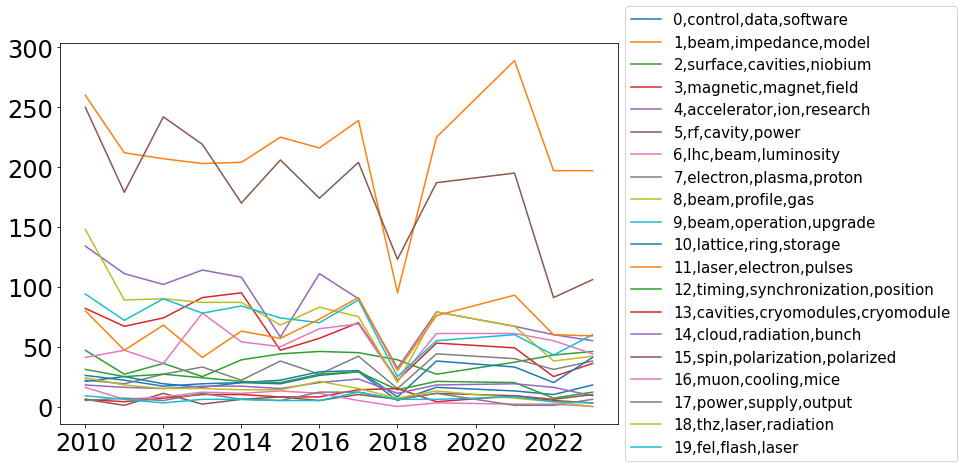

In [75]:
f = plt.figure()

df = pd.DataFrame(index = sorted(set(df_time_ipac['Year'])))
for topic in sorted(set(df_time_ipac['Topic'])):
    if topic == -1:
        continue
    counter = Counter(df_time_ipac[df_time_ipac['Topic'] == topic]['Year'].values)
    for year in sorted(counter.keys()):
        df.loc[year, topic] = counter[year]
df = df.fillna(0)
df = df.rename(columns = {c : ",".join(topic_labels[topic_labels['Topic'] == c]['Name'].values[0].split('_')[:4]) for c in df.columns})
#plt.plot(df)
# plt.show()
df = df.loc[:,df.sum(0) > 75]
# df.loc[:,'Sum'] = df.sum(1)
df = df.loc[df.index != 2020,:]
# df = df.loc[df.index != 2018,:]
fig = df.iloc[:,:].plot(figsize = (10,7), ax = f.gca())
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize = 15)
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
f.savefig('/home/sulcan/TU2AO02_4.pdf', bbox_inches='tight')

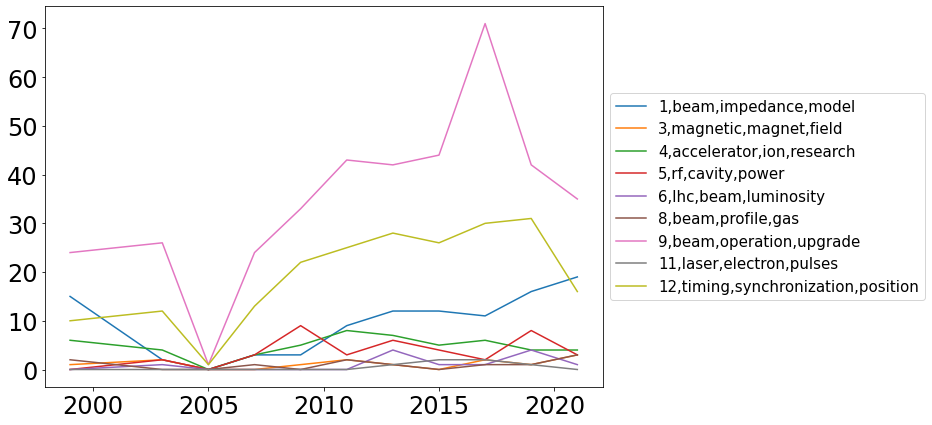

In [21]:
f = plt.figure()
df = pd.DataFrame(index = sorted(set(df_time_icalepcs['Year'])))
for topic in sorted(set(df_time_icalepcs['Topic'])):
    if topic == -1:
        continue
    counter = Counter(df_time_icalepcs[df_time_icalepcs['Topic'] == topic]['Year'].values)
    for year in sorted(counter.keys()):
        df.loc[year, topic] = counter[year]
df = df.fillna(0)
df = df.rename(columns = {c : ",".join(topic_labels[topic_labels['Topic'] == c]['Name'].values[0].split('_')[:4]) for c in df.columns})
#plt.plot(df)
# plt.show()
df = df.loc[:,df.sum(0) > 5]
fig = df.iloc[:,1:].plot(figsize = (10,7), ax = f.gca())
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize = 15)
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)

plt.savefig('/home/sulcan/TU2AO02_5.pdf',bbox_inches='tight')

In [ ]:
'''
repr_docs = topic_model.get_representative_docs()
for i in range(nr_topics-1):
    topic = topic_model.get_topic(i)
    best = np.argsort(probs[:,i])[::-1]
    
    
    print("\n\n",i, ",".join([t for t,_ in topic]))
    print("\n\n".join([list(abstracts.keys())[k] + list(abstracts.values())[k] for k in best[:3]]))
'''

### Deeper analysis of one category

In [ ]:
T = 0
outlier_abstracts = {list(abstracts.keys())[i] : abstracts[list(abstracts.keys())[i]]  for i,t in enumerate(topics) if t == T}
outlier_et = et[np.array(topics) == T,:]

In [ ]:
outlier_topic_model = BERTopic(verbose=True, 
                       vectorizer_model= vectorizer_model, 
                       embedding_model = embedding,
                       calculate_probabilities = True)
outlier_topics, outlier_probs = outlier_topic_model.fit_transform(list(outlier_abstracts.values()))

topic_model.save(data_folder + f'/bertopic/bertopic_topic_{T}.pkl')

In [ ]:
outlier_topic_model.visualize_topics()

In [ ]:
# 
# POINTS
# 
df = pd.DataFrame.from_dict({'x' : outlier_et[:,0], 'y' : outlier_et[:,1], 
                             'Topic' : outlier_topics,
                             'Title' : [(titles[k] if titles[k] != None else k) for k in outlier_abstracts]})
df = df[df['Topic'] != -1]
df['Topic'] = [str(x).zfill(2) for x in df['Topic']]

fig1 = px.scatter(df, x = 'x', y = 'y', 
                 color = 'Topic', 
                 custom_data=['Title'],
                 opacity=0.15,
                 color_discrete_sequence=px.colors.qualitative.G10)
fig1.update_traces(mode="markers", hovertemplate = '%{customdata[0]}')

#
# TOPICS 
#
topic_labels = topic_model.get_topic_info()
# topic_labels.loc[topic_labels['Topic'] == t,'Name'].values[0]
topic_centers_x = {t : outlier_et[np.array(outlier_topics)==t,0].mean() for t in set(outlier_topics) if t != -1}
topic_centers_y = {t : outlier_et[np.array(outlier_topics)==t,1].mean() for t in set(outlier_topics) if t != -1}
df_topic_centers_x = pd.DataFrame.from_dict({'Topic' : list(topic_centers_x.keys()), 'x' : list(topic_centers_x.values())}).set_index('Topic')
df_topic_centers_y = pd.DataFrame.from_dict({'Topic' : list(topic_centers_y.keys()), 'y' : list(topic_centers_y.values())}).set_index('Topic')
df_topic_centers = df_topic_centers_x.join(df_topic_centers_y).join(topic_labels.set_index('Topic'))
df_topic_centers['Name'] = df_topic_centers['Name'].map(lambda x : ",".join(x.split('_')[:4]))
df_topic_centers = df_topic_centers.reset_index('Topic')
df_topic_centers['Topic'] = [str(x).zfill(2) for x in df_topic_centers['Topic']]


fig2 = px.scatter(df_topic_centers,x = 'x',y = 'y', text = 'Name', opacity = 1)
fig2.update_traces(textfont_size=17)

fig3 = go.Figure(data=fig2.data + fig1.data)
fig3.update_xaxes(showgrid=False, 
                 showticklabels=False,
                 visible=False)
fig3.update_yaxes(# scaleanchor="x", 
                 # scaleratio=0.8,
                 showgrid=False,
                 showticklabels=False,
                 visible=False)
fig3.update_layout(autosize=False, 
                   width=800, height=600,
                   showlegend=False, 
                   plot_bgcolor='rgba(0, 0, 0, 0)',
                   margin=dict(l=0, r=0, b=0, t=0, pad=0))

fig3.show()
fig3.write_image(f"/home/sulcan/BERTopic_documents_topic_{T}.pdf")

In [ ]:
fig = px.scatter(df_topic_centers,x = 'x',y = 'y', size = 'Count', color = 'Topic', text = 'Name', 
                 opacity = 0.5, size_max = 40)

fig.update_traces(textfont_size=15,
                  marker=dict(
                      color='Gray',
                      line=dict(color='Black', width=2)
                  ),
                  textposition='top center')
fig.update_xaxes(showgrid=False, 
                 showticklabels=False,
                 visible=False)
fig.update_yaxes(# scaleanchor="x", 
                 # scaleratio=0.8,
                 showgrid=False,
                 showticklabels=False,
                 visible=False)
fig.update_layout(autosize=False, 
                   width=800, height=600,
                   showlegend=False, 
                   plot_bgcolor='rgba(0, 0, 0, 0)',
                   margin=dict(l=0, r=0, b=0, t=0, pad=0))
fig.show()
fig.write_image(f"/home/sulcan/BERTopic_topics_topic_{T}.pdf")

### Development of topics over time with 1D embedding

In [ ]:
umap1d = UMAP(n_components=1, metric = 'cosine' ,random_state = 42, verbose = True)
# et1d = umap1d.fit_transform(e)
plt.hist(et1d,512)
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (10,30)
df_time = pd.DataFrame.from_dict({'Topic' : topics,
                                  'Conference' : [re.sub(r'\d', '', k.split('/')[-2])  for k in abstracts.keys()],
                                  'Year' :   [int(re.sub(r'\D', '', k.split('/')[-2])) for k in abstracts.keys()],
                                  '1D' : et1d.tolist()})
df_time = df_time.set_index('Topic')
df_time = df_time.join(topic_labels.set_index('Topic'))
df_time = df_time.reset_index('Topic') 

df_time_ipac = df_time[df_time['Conference'] == 'ipac']
df_time_icalepcs = df_time[df_time['Conference'] == 'icalepcs']

# ticks with topics
topic_xticks = [[],[]]
for topic in range(nr_topics-1):
    topic_mean = np.array(list(df_time[df_time['Topic'] == topic]['1D'])).mean()
    name = df_time[df_time['Topic'] == topic]['Name'].values[0]
    name = ",".join(name.split('_')[:3])
    topic_xticks[0].append(topic_mean)
    topic_xticks[1].append(name)

In [ ]:
xall = df_time_icalepcs['1D']
years = sorted(set(list(df_time_icalepcs['Year'].values)))
for i, year in enumerate(years):
    if year == 2005:
        plt.xticks(topic_xticks[0][1::2],topic_xticks[1][1::2], rotation = 90, fontsize = 13)
        continue
    x = np.array(list(df_time_icalepcs[df_time_icalepcs['Year'] == year]['1D']))
    plt.subplot(len(years),1,i+1)
    plt.hist(x,64, range = (xall.min()[0], xall.max()[0]),
             alpha = 0.35, color= 'r')
    plt.title(f'ICALEPCS {year}')
    plt.xticks([])
    
plt.xticks(topic_xticks[0][::2],topic_xticks[1][::2], rotation = 90, fontsize = 13)
plt.savefig('/home/sulcan/ICALEPCS.pdf',bbox_inches='tight')
plt.show()

In [ ]:
xall = df_time_ipac['1D']
years = sorted(set(list(df_time_ipac['Year'].values)))
for i, year in enumerate(years):
    if year == 2020:
        plt.xticks(topic_xticks[0][1::2],topic_xticks[1][1::2], rotation = 90, fontsize = 13)
        continue
    x = np.array(list(df_time_ipac[df_time_ipac['Year'] == year]['1D']))
    plt.subplot(len(years),1,i+1)
    plt.hist(x,128, range = (xall.min()[0], xall.max()[0]),
             alpha = 0.35, color= 'b')
    plt.title(f'IPAC {year}')
    plt.xticks([])
    
plt.xticks(topic_xticks[0][::2],topic_xticks[1][::2], rotation = 90, fontsize = 13)
plt.savefig('/home/sulcan/IPAC.pdf',bbox_inches='tight')
plt.show()

## NMF

This is a simple (and quite straighforward) implementation of Non-Negatove Matrix Factorization, which produces quite some interesting results. Combined with the UMAP embedding from SimCSE, we can see maybe even better distribution of keywords in topics.

One of the main problems of the NMF is that 

In [ ]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
plt.rcParams['figure.figsize'] = 20, 5



with gzip.open(data_folder + '/bertopic/embedding.pkl.gzip','rb') as f:
    data = pickle.load(f)
    e = data['embedding']
    et = data['reduced_embedding']

def topic_features(tfidf, topic_model, N = 5):
    features = tfidf.get_feature_names_out()

    C = topic_model.components_
    topics = {}
    for c in range(C.shape[0]):
        idx = np.argsort(C[c,:])[::-1]
        topics[c] = ",".join([features[idx[i]] for i in range(N)])
    return topics


In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english')
X = tfidf_vectorizer.fit_transform(abstracts.values(), )

In [ ]:
topic_model = NMF(n_components=32,random_state=42,beta_loss="frobenius", l1_ratio = 0.9).fit(X)
topic_labels = topic_features(tfidf_vectorizer, topic_model)

In [ ]:
Xt = topic_model.transform(X)
tf = topic_features(tfidf_vectorizer, topic_model)

In [ ]:

plt.rcParams['figure.figsize'] = 20,20

topics = np.argmax(Xt,1)
ec = []
size = {}
for t in range(topic_model.n_components_):
    idx = np.where(topics == t)[0]
    size[t] = X[:,idx].sum()
    ec.append(et[idx,:].mean(0))
ec = np.stack(ec,0)
plt.plot(ec[:,0],ec[:,1],'.')

for t in range(topic_model.n_components_):
    plt.annotate(tf[t], ec[t,:])
plt.show()


In [ ]:
# 
# POINTS
# 
df = pd.DataFrame.from_dict({'x' : et[:,0], 'y' : et[:,1], 
                             'Topic' : topics,
                             'Title' : [(titles[k] if titles[k] != None else k) for k in abstracts]})
df = df[df['Topic'] != -1]
df['Topic'] = [str(x).zfill(2) for x in df['Topic']]

fig1 = px.scatter(df, x = 'x', y = 'y', 
                 color = 'Topic', 
                 custom_data=['Title'],
                 opacity=0.15,
                 color_discrete_sequence=px.colors.qualitative.G10)

fig1.update_traces(mode="markers", hovertemplate = '%{customdata[0]}')
'''
#
# TOPICS 
#
# topic_labels.loc[topic_labels['Topic'] == t,'Name'].values[0]
topic_labels = pd.DataFrame(topic_labels, index = [0]).T
topic_centers_x = {t : et[np.array(topics)==t,0].mean() for t in set(topics) if t != -1}
topic_centers_y = {t : et[np.array(topics)==t,1].mean() for t in set(topics) if t != -1}
df_topic_centers_x = pd.DataFrame.from_dict({'Topic' : list(topic_centers_x.keys()), 'x' : list(topic_centers_x.values())}).set_index('Topic')
df_topic_centers_y = pd.DataFrame.from_dict({'Topic' : list(topic_centers_y.keys()), 'y' : list(topic_centers_y.values())}).set_index('Topic')
df_topic_centers = df_topic_centers_x.join(df_topic_centers_y).join(topic_labels.set_index('Topic'))
df_topic_centers['Name'] = df_topic_centers['Name'].map(lambda x : ",".join(x.split('_')[:3]))
df_topic_centers = df_topic_centers.reset_index('Topic')
df_topic_centers['Topic'] = [str(x).zfill(2) for x in df_topic_centers['Topic']]


fig2 = px.scatter(df_topic_centers,x = 'x',y = 'y', text = 'Name', opacity = 1)
fig2.update_traces(textfont_size=16)

fig3 = go.Figure(data=fig2.data + fig1.data)
fig3.update_xaxes(showgrid=False, 
                 showticklabels=False,
                 visible=False)
fig3.update_yaxes(# scaleanchor="x", 
                 # scaleratio=0.8,
                 showgrid=False,
                 showticklabels=False,
                 visible=False)
'''
fig1.update_layout(autosize=False, 
                   width=800, height=600,
                   showlegend=False, 
                   plot_bgcolor='rgba(0, 0, 0, 0)',
                   margin=dict(l=0, r=0, b=0, t=0, pad=0))


fig1.show()
# fig3.write_image("/home/sulcan/BERTopic_documents.pdf")